In [1]:
import json
import random
import warnings
from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.optimizers import Adagrad
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, f1_score
from sklearn.utils import class_weight
from spacy.lang.tr import Turkish
from spacy.tokenizer import Tokenizer
from tqdm import tqdm
from transformers import AutoModel, AutoTokenizer

Using TensorFlow backend.


In [2]:
train_path = 'Boun Twitter Data/train.json'
val_path = 'Boun Twitter Data/validation.json'
test_path = 'Boun Twitter Data/test.json'
cappy_path = 'Other Data/cappy.json'
bege_path = 'Other Data/berkcan.json'
netflix_path = 'Other Data/netflix.json'
device = 'cuda'

In [3]:
def filter(text):
    final_text = ''
    for word in text.split():
        if word.startswith('@'):
            continue
        elif word[-3:] in ['com', 'org']:
            continue
        elif word.startswith('pic') or word.startswith('http') or word.startswith('www'):
            continue
        else:
            final_text += word+' '
    return final_text

In [4]:
tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-128k-uncased")
bert = AutoModel.from_pretrained("dbmdz/bert-base-turkish-128k-uncased").to(device)

def feature_extraction(text):
    x = tokenizer.encode(filter(text))
    with torch.no_grad():
        x, _ = bert(torch.stack([torch.tensor(tokenizer.encode(text))]).to(device))
        return list(x[0][0].cpu().numpy())

In [5]:
with open(train_path, 'r') as f:
    train = json.load(f)
with open(val_path, 'r') as f:
    val = json.load(f)
with open(test_path, 'r') as f:
    test = json.load(f)


In [6]:
mapping = {'negative':0, 'neutral':1, 'positive':2}
def data_prep(dataset):
    X = []
    y = []
    for element in tqdm(dataset):
        X.append(feature_extraction(element['sentence']))
        y_val = np.zeros(3)
        y_val[mapping[element['value']]] = 1
        y.append(y_val)
    return np.array(X), np.array(y)

X_train, y_train = data_prep(train)
X_val, y_val = data_prep(val)
X_test, y_test = data_prep(test)

100%|██████████| 1592/1592 [00:10<00:00, 144.84it/s]


## Training a Model with Keras

In [7]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(np.argmax(y_train, 1)), np.argmax(y_train, 1))
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

model = Sequential()
model.add(Dense(512, activation='tanh', input_shape=(768,)))
model.add(Dropout(0.5))
model.add(Dense(128, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=Adagrad(),
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               393728    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                

In [8]:
history = model.fit(np.array(X_train), np.array(y_train),
                    batch_size=64,
                    epochs=500,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    class_weight=class_weights,
                    callbacks = [es])

Train on 5733 samples, validate on 639 samples
Epoch 1/500
5733/5733 [==============================] - 0s 54us/step - loss: 1.2683 - accuracy: 0.4328 - val_loss: 1.0161 - val_accuracy: 0.5290
Epoch 2/500
5733/5733 [==============================] - 0s 31us/step - loss: 1.1460 - accuracy: 0.4521 - val_loss: 1.0172 - val_accuracy: 0.5305
Epoch 3/500
5733/5733 [==============================] - 0s 32us/step - loss: 1.0892 - accuracy: 0.4753 - val_loss: 0.9223 - val_accuracy: 0.5305
Epoch 4/500
5733/5733 [==============================] - 0s 31us/step - loss: 1.0237 - accuracy: 0.5097 - val_loss: 0.8978 - val_accuracy: 0.5822
Epoch 5/500
5733/5733 [==============================] - 0s 31us/step - loss: 0.9699 - accuracy: 0.5423 - val_loss: 0.8739 - val_accuracy: 0.5884
Epoch 6/500
5733/5733 [==============================] - 0s 36us/step - loss: 0.9343 - accuracy: 0.5601 - val_loss: 0.8749 - val_accuracy: 0.5759
Epoch 7/500
5733/5733 [==============================] - 0s 31us/step - loss:

5733/5733 [==============================] - 0s 32us/step - loss: 0.6542 - accuracy: 0.7410 - val_loss: 0.8309 - val_accuracy: 0.6729
Epoch 57/500
5733/5733 [==============================] - 0s 32us/step - loss: 0.6477 - accuracy: 0.7418 - val_loss: 0.8459 - val_accuracy: 0.6745
Epoch 58/500
5733/5733 [==============================] - 0s 32us/step - loss: 0.6451 - accuracy: 0.7450 - val_loss: 0.8243 - val_accuracy: 0.6854
Epoch 59/500
5733/5733 [==============================] - 0s 33us/step - loss: 0.6523 - accuracy: 0.7450 - val_loss: 0.8494 - val_accuracy: 0.6808
Epoch 60/500
5733/5733 [==============================] - 0s 32us/step - loss: 0.6482 - accuracy: 0.7455 - val_loss: 0.8346 - val_accuracy: 0.6714
Epoch 61/500
5733/5733 [==============================] - 0s 32us/step - loss: 0.6456 - accuracy: 0.7541 - val_loss: 0.8317 - val_accuracy: 0.6651
Epoch 62/500
5733/5733 [==============================] - 0s 32us/step - loss: 0.6501 - accuracy: 0.7436 - val_loss: 0.8274 - val_a

In [10]:
y_true, y_pred = np.argmax(y_test, 1), np.argmax(model.predict(X_test), 1)
print(classification_report(y_true, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.529     0.682     0.596       280
           1      0.847     0.696     0.764       843
           2      0.597     0.684     0.638       469

    accuracy                          0.690      1592
   macro avg      0.658     0.688     0.666      1592
weighted avg      0.717     0.690     0.697      1592



# Analysis

## Cappy Analysis

In [11]:
cappy_df = pd.read_json(cappy_path).query('is_retweet==False').drop_duplicates(['text'])[['text', 'datetime']]
cappy_df['value'] = 0
#-1 negative 0 neutral 1 positive
for idx, row in tqdm(cappy_df.iterrows()):
    X = feature_extraction(row['text'])
    cappy_df.at[idx, 'value'] = np.argmax(model.predict(np.array(X).reshape(1, -1)))-1

13717it [01:58, 115.31it/s]


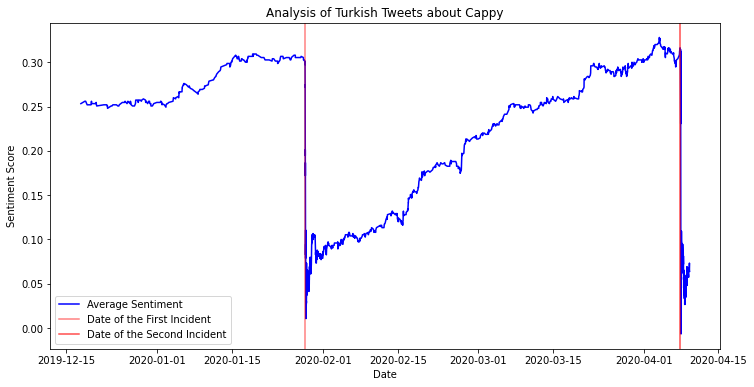

In [12]:
incident1 = datetime.strptime('2020-01-28 15:20:00', '%Y-%m-%d %H:%M:%S')
incident2 = datetime.strptime('2020-04-07 19:34:00', '%Y-%m-%d %H:%M:%S')
dates = np.array(cappy_df['datetime'])
indices = np.argsort(dates)[5300:]
window = 750

dates = dates[indices][window:]
values = np.array(cappy_df['value'])[indices]
windows = pd.Series(values).rolling(window)
moving_averages = windows.mean()[window:]


plt.figure(figsize=(12,6))
plt.plot(dates, moving_averages, color='blue', label='Average Sentiment')

plt.axvline(incident1, 0, 1, label='Date of the First Incident', color='red', alpha=0.5)
plt.axvline(incident2, 0, 1, label='Date of the Second Incident', color='red', alpha=0.7)
plt.title('Analysis of Turkish Tweets about Cappy')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.legend();

## Netflix Analysis

In [13]:
netflix_df = pd.read_json(netflix_path).query('is_retweet==False').drop_duplicates(['text'])[['text', 'datetime']]
netflix_df['value'] = 0
#-1 negative 0 neutral 1 positive
for idx, row in tqdm(netflix_df.iterrows()):
    X = feature_extraction(row['text'])
    netflix_df.at[idx, 'value'] = np.argmax(model.predict(np.array(X).reshape(1, -1)))-1

13948it [02:03, 112.68it/s]


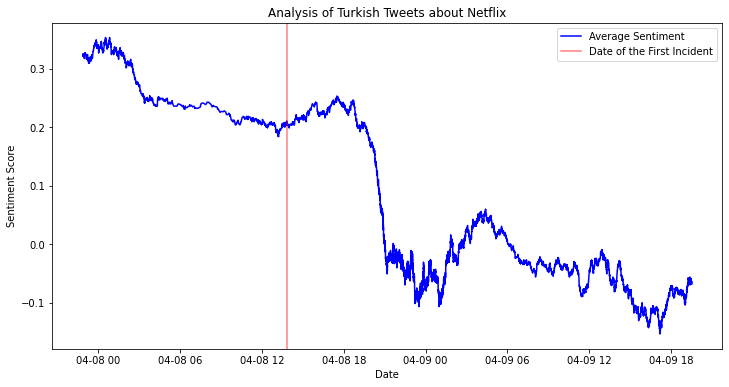

In [14]:
incident1 = datetime.strptime('2020-04-08 13:48:00', '%Y-%m-%d %H:%M:%S')
dates = np.array(netflix_df['datetime'])
indices = np.argsort(dates)
window = 750

dates = dates[indices][window:]
values = np.array(netflix_df['value'])[indices]
windows = pd.Series(values).rolling(window)
moving_averages = windows.mean()[window:]


plt.figure(figsize=(12,6))
plt.plot(dates, moving_averages, color='blue', label='Average Sentiment')

plt.axvline(incident1, 0, 1, label='Date of the First Incident', color='red', alpha=0.5)
plt.title('Analysis of Turkish Tweets about Netflix')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.legend();

## Berkcan Guven Analysis

In [15]:
bege_df = pd.read_json(bege_path).query('is_retweet==False').drop_duplicates(['text'])[['text', 'datetime']]
bege_df['value'] = 0
#-1 negative 0 neutral 1 positive
for idx, row in tqdm(bege_df.iterrows()):
    X = feature_extraction(row['text'])
    bege_df.at[idx, 'value'] = np.argmax(model.predict(np.array(X).reshape(1, -1)))-1

14274it [01:58, 120.01it/s]


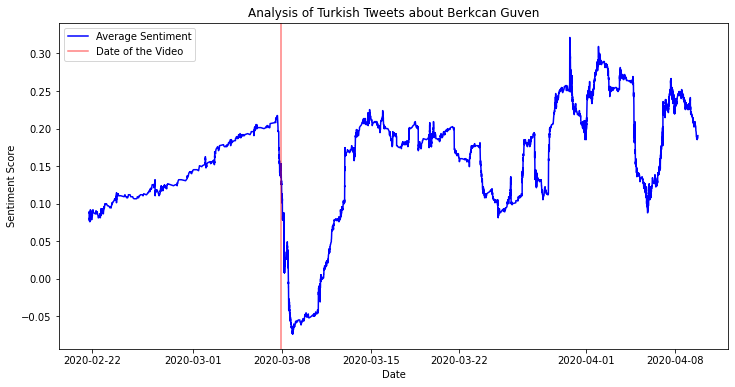

In [16]:
incident1 = datetime.strptime('2020-03-07 23:11:00', '%Y-%m-%d %H:%M:%S')
dates = np.array(bege_df['datetime'])
indices = np.argsort(dates)
window = 750

dates = dates[indices][window:]
values = np.array(bege_df['value'])[indices]
windows = pd.Series(values).rolling(window)
moving_averages = windows.mean()[window:]


plt.figure(figsize=(12,6))
plt.plot(dates, moving_averages, color='blue', label='Average Sentiment')

plt.axvline(incident1, 0, 1, label='Date of the Video', color='red', alpha=0.5)
plt.title('Analysis of Turkish Tweets about Berkcan Guven')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.legend();